# Analysis of a OOK radio transmission
## Abstract
In this notebook I explain how to read and replay a signal transmitted with on-off keing (OOK) with use of a software defined radio (SDR). I reference the software, hardware and the resources that helped me get to the goal. I also presend my own code along with the explanation. 

## Introduction
 - early insiprations (arduino, yt)
 - possible applications
 - plan of action

## Requirements
General blabla

### Hardware
- SDR
- PC
 
### Software
 - Python
 - GQRX 2.15.8
 
## Recording the signal
This matter is well described on the Internet (for example here) so I'll only briefly list the steps.

1. Plug in your SDR dongle.
2. Turn on GQRX and start listening.
3. Start recording raw I/Q signal.
4. Enjoy you large file with the raw signal.

The files are quickly getting large with default settings (1GB corresponds roughly to 1min of recording on my setup) so make sure to pause the recording as soon as the message ends. The program also offers many options to demodulate the signal and save it as sound (.wav) but it doesn't seem useful in our case.

## Decoding the raw signal
My first attempt to decode the message was quite a dirty workaround. I'd open the files in Audacity (piece of open source software for audio operations) and by experimenting with the options I'd get a signal that could be interpreted as highs and lows. As I spent more time on the subject, I realized that the binary file probably can be read directly in Python, had I only knew its structure. Browsing the Internet I found out that the signal is composed of pairs of 32 bit floats, which translates to an array of 64 bit complex numbers. Equiped with this knowledge I proceeded to the implementation.

In [25]:
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
import numpy as np
import pandas as pd

In [2]:
# get info about the file
input_filename = "gqrx_20220810_095656_434541100_1800000_fc.raw"

metadata = input_filename.split('_')
source_program, date, time, frequency, sample_rate, device = metadata

timestamp = datetime.datetime.strptime(date+time, '%Y%m%d%H%M%S')
frequency = float(frequency)
sample_rate = float(sample_rate)

print(
    "Metadata:"
    f"\n\t- source_program: {source_program}"
    f"\n\t- timestamp: {timestamp} UTC"
    f"\n\t- OOK signal frequency: {frequency:,} Hz"
    f"\n\t- sample_rate: {sample_rate:,} Hz"
    
)

Metadata:
	- source_program: gqrx
	- timestamp: 2022-08-10 09:56:56 UTC
	- OOK signal frequency: 434,541,100.0 Hz
	- sample_rate: 1,800,000.0 Hz


In [5]:
# read data
with open(input_filename, "rb") as f:
    raw_data = np.fromfile(f, dtype=np.complex64)

print(f"Signal length: {len(raw_data)}")

Signal length: 140000


<IPython.core.display.Javascript object>


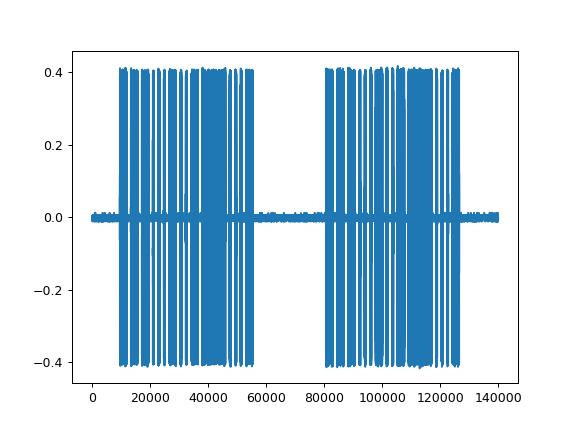

In [39]:
# get a preview of the signal
%matplotlib notebook
plt.plot(raw_data.imag)

In [33]:
# create a dataframe to facilitate further work
raw_cut = raw_data[5_000:60_000] # the signal obviously repeats so we'll only consider the first occurence.
df = pd.DataFrame(
    {
        "real": raw_cut.real,
        "imag": raw_cut.imag,
        "time": pd.date_range(timestamp, periods=len(raw_cut), freq=pd.Timedelta(seconds=1/sample_rate))
    }
)
df

,real,imag,time
0,-0.000827,-0.002868,2022-08-10 09:56:56.000000
1,0.001241,-0.003511,2022-08-10 09:56:56.000001
2,0.001241,-0.003511,2022-08-10 09:56:56.000002
3,0.001241,-0.003511,2022-08-10 09:56:56.000003
4,-0.000827,0.004945,2022-08-10 09:56:56.000004
...,...,...,...
54995,-0.000942,-0.002881,2022-08-10 09:56:56.054995
54996,0.001413,-0.003491,2022-08-10 09:56:56.054996
54997,-0.000942,0.004932,2022-08-10 09:56:56.054997
54998,-0.000942,-0.002881,2022-08-10 09:56:56.054998


<IPython.core.display.Javascript object>


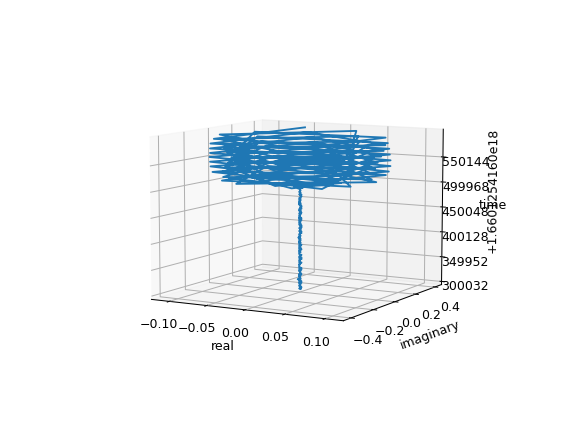

Text(0.5, 0, 'time')

In [43]:
# Our data is in fact 3d, so we can visualize it as such.
fig = plt.figure()
ax = plt.axes(projection='3d')
df2 = df.iloc[4300:4600, :]
ax.plot3D(df2.real, df2.imag, df2.time.apply(lambda x: x.value), markersize=1)
ax.set_xlabel("real")
ax.set_ylabel("imaginary")
ax.set_zlabel("time")

It seems like our signal is a kind of spiral combined with a 10-arm star that slowly rotates. Whatever it means, at the moment we only want to distinguish between the excited and unexcited periods and most likely the modulus of the complex numbers will be the best thing to look at. Figure one was already promising, with a clear binary pattern, however when zoomed it reveals that the excited periods are full of points at various heights which make it harder to digitize. So far I was using a running average that worked well, but I feel like the absolute value of the modulus is even better.

<IPython.core.display.Javascript object>


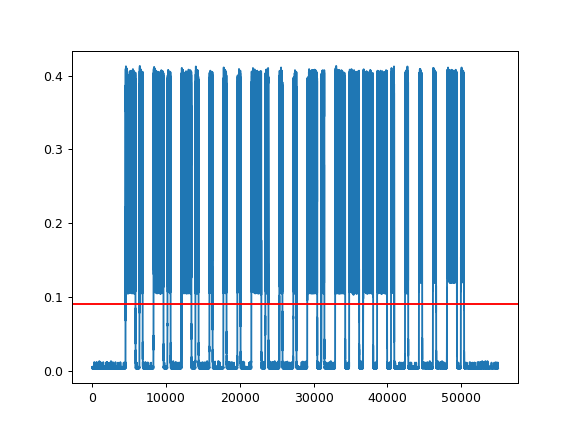

In [42]:
%matplotlib notebook
df["modulus"] = ((df.real**2 + df.imag**2)**0.5).abs()
df.modulus.plot()
plt.axhline(0.09, c="red")

<IPython.core.display.Javascript object>


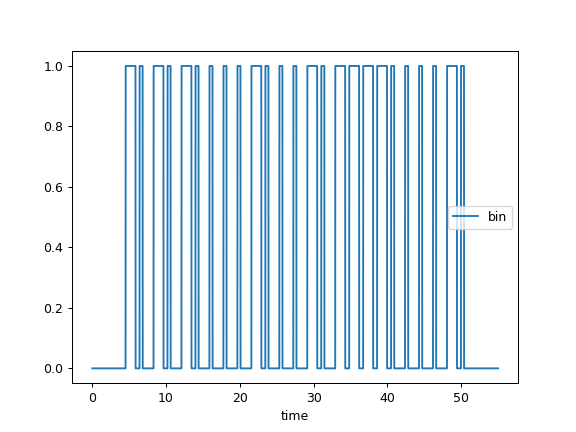

<AxesSubplot:xlabel='time'>

In [54]:
# extract the signal and plot
%matplotlib notebook

threshold = 0.09 # read from the graph
df["bin"] = df.modulus.apply(lambda x: 1 if x > threshold else 0) # digitization
signal = df[["bin"]]
signal.index = df.time.apply(lambda x: (x.value - df.time[0].value) / 1_000_000) # time in miliseconds
signal.plot()